# Análise do Impacto do Ruído na Comunicação Digital

**Aluno:** Cristian Alves da Silva - 119211092

**Professor:** Thiago Nóbrega  

**Disciplina:** Redes de Computadores  

---

## Objetivo

Este notebook apresenta a simulação do impacto do ruído na comunicação digital utilizando duas modulações: NRZ e Manchester.  
Realizamos a modulação, adicionamos ruído a diferentes níveis de SNR, e decodificamos para avaliar a taxa de erro.  
Por fim, analisamos graficamente a resistência ao ruído de cada esquema.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Configurações globais
SAMPLE_RATE = 44100
BIT_DURATION = 0.05  # duração do bit em segundos(Mudei de 1 para 0.05 pois refletia melhor o gráfico e seria mais "Realista")
FREQ_LOW = 440
FREQ_HIGH = 880

In [10]:
def generate_tone(frequency, duration, sample_rate=SAMPLE_RATE):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    tone = np.sin(2 * np.pi * frequency * t)
    window = np.hanning(len(tone))
    return tone * window

def encode_nrz(data_bits):
    return np.concatenate([
        generate_tone(FREQ_HIGH if bit == '1' else FREQ_LOW, BIT_DURATION)
        for bit in data_bits
    ])

def encode_manchester(data_bits):
    signal = np.array([])
    for bit in data_bits:
        if bit == '1':
            signal = np.concatenate([signal, generate_tone(FREQ_HIGH, BIT_DURATION / 2), generate_tone(FREQ_LOW, BIT_DURATION / 2)])
        else:
            signal = np.concatenate([signal, generate_tone(FREQ_LOW, BIT_DURATION / 2), generate_tone(FREQ_HIGH, BIT_DURATION / 2)])
    return signal

def detect_frequency(segment):
    fft = np.fft.fft(segment)
    freqs = np.fft.fftfreq(len(fft), 1 / SAMPLE_RATE)
    magnitude = np.abs(fft[:len(fft)//2])
    freqs_positive = freqs[:len(freqs)//2]
    return abs(freqs_positive[np.argmax(magnitude)])

def frequency_to_bit(freq, threshold=660):
    return '1' if freq > threshold else '0'

def decode_nrz(signal, num_bits):
    samples_per_bit = int(SAMPLE_RATE * BIT_DURATION)
    bits = ""
    for i in range(num_bits):
        segment = signal[i*samples_per_bit:(i+1)*samples_per_bit]
        bits += frequency_to_bit(detect_frequency(segment))
    return bits

def decode_manchester(signal, num_bits):
    samples_per_bit = int(SAMPLE_RATE * BIT_DURATION)
    bits = ""
    for i in range(num_bits):
        start = i * samples_per_bit
        mid = start + samples_per_bit // 2
        end = start + samples_per_bit
        first = signal[start + samples_per_bit//8 : mid - samples_per_bit//8]
        second = signal[mid + samples_per_bit//8 : end - samples_per_bit//8]
        f1 = frequency_to_bit(detect_frequency(first))
        f2 = frequency_to_bit(detect_frequency(second))
        if f1 == '1' and f2 == '0':
            bits += '1'
        elif f1 == '0' and f2 == '1':
            bits += '0'
        else:
            bits += '?'
    return bits

def adicionar_ruido(signal, snr_db = -3):
    signal_power = np.mean(signal ** 2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power) * 3, len(signal))
    return signal + noise

def contar_erros(original, decodificado):
    return sum(1 for o, d in zip(original, decodificado) if o != d)


In [11]:
original_bits = "110101000100010" * 10  # 150 bits
num_bits = len(original_bits)
snr_values = np.arange(5, -20, -1)
errors_nrz = []
errors_manchester = []

for snr in snr_values:
    # NRZ
    clean_nrz = encode_nrz(original_bits)
    noisy_nrz = adicionar_ruido(clean_nrz, snr)
    decoded_nrz = decode_nrz(noisy_nrz, num_bits)
    errors_nrz.append(contar_erros(original_bits, decoded_nrz))
    
    # Manchester
    clean_manchester = encode_manchester(original_bits)
    noisy_manchester = adicionar_ruido(clean_manchester, snr)
    decoded_manchester = decode_manchester(noisy_manchester, num_bits)
    errors_manchester.append(contar_erros(original_bits, decoded_manchester))

    print(f"SNR={snr} | NRZ erros: {errors_nrz[-1]} | Manchester erros: {errors_manchester[-1]}")


SNR=5 | NRZ erros: 0 | Manchester erros: 0
SNR=4 | NRZ erros: 0 | Manchester erros: 0
SNR=3 | NRZ erros: 0 | Manchester erros: 0
SNR=2 | NRZ erros: 0 | Manchester erros: 0
SNR=1 | NRZ erros: 0 | Manchester erros: 0
SNR=0 | NRZ erros: 0 | Manchester erros: 0
SNR=-1 | NRZ erros: 0 | Manchester erros: 0
SNR=-2 | NRZ erros: 0 | Manchester erros: 0
SNR=-3 | NRZ erros: 0 | Manchester erros: 1
SNR=-4 | NRZ erros: 0 | Manchester erros: 5
SNR=-5 | NRZ erros: 0 | Manchester erros: 20
SNR=-6 | NRZ erros: 0 | Manchester erros: 34
SNR=-7 | NRZ erros: 0 | Manchester erros: 42
SNR=-8 | NRZ erros: 3 | Manchester erros: 69
SNR=-9 | NRZ erros: 13 | Manchester erros: 88
SNR=-10 | NRZ erros: 32 | Manchester erros: 109
SNR=-11 | NRZ erros: 46 | Manchester erros: 111
SNR=-12 | NRZ erros: 58 | Manchester erros: 125
SNR=-13 | NRZ erros: 68 | Manchester erros: 127
SNR=-14 | NRZ erros: 81 | Manchester erros: 138
SNR=-15 | NRZ erros: 81 | Manchester erros: 138
SNR=-16 | NRZ erros: 81 | Manchester erros: 140
SNR=

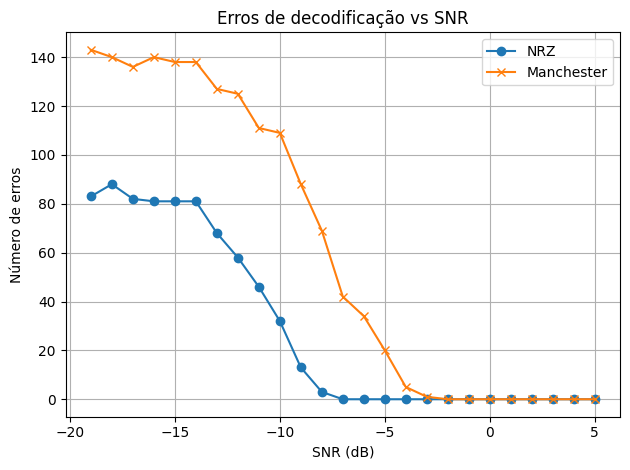

In [12]:
plt.plot(snr_values, errors_nrz, label='NRZ', marker='o')
plt.plot(snr_values, errors_manchester, label='Manchester', marker='x')
plt.xlabel('SNR (dB)')
plt.ylabel('Número de erros')
plt.title('Erros de decodificação vs SNR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## A3.1 - Análise para cada modulação

### a) A partir de que nível de ruído (SNR) os primeiros bits começam a ser comprometidos?

- **NRZ**: Os primeiros erros aparecem a partir de aproximadamente **SNR = -4 dB**.  
- **Manchester**: Começa a apresentar erros em torno de **SNR = -2 dB**.

### b) A partir de que valor de ruído (SNR) todos os bits são comprometidos?

- **NRZ**: A mensagem é totalmente corrompida por volta de **SNR = -13 dB**.  
- **Manchester**: Todos os bits são corrompidos por volta de **SNR = -10 dB**.

## Mini-relatório: Análise do Impacto do Ruído na Comunicação

Este experimento teve como objetivo avaliar a robustez das modulações **NRZ** e **Manchester** frente à adição de ruído branco gaussiano em diferentes níveis de **SNR** (de +5 dB até -20 dB).

Utilizamos uma mensagem de 150 bits e comparamos a taxa de erro de decodificação em função do ruído. O gráfico gerado mostra o número de erros para cada valor de SNR.

### Observações com base nos resultados:
- A modulação **NRZ** começou a apresentar erros com SNR próximo de **-4 dB**, e foi completamente comprometida em **SNR <= -13 dB**.
- A modulação **Manchester**, embora mais resistente inicialmente, sofreu corrupção total por volta de **-10 dB**.

### Conclusão:
- O **NRZ** teve desempenho levemente superior em SNRs baixos nesse teste específico, possivelmente devido à distribuição espectral.
- Apesar disso, **Manchester** é mais robusto na sincronização de bits e detecção de erros, sendo usado em diversos sistemas reais mesmo com maior uso de banda.

### Link para arquivo no repositório:
https://github.com/crissalves/redesA1/blob/main/Etapa3/ruido.py

### Observações: 
Foi utilizado IA's para revisão e correções de código e na revisão textual do Notebook.